# ML Project Assignment - Samuele Ceol

## Classification task on Stroke Prediction Dataset

## Table of Contents
* [CHAPTER 0 - INTRODUCTION](#0)
    * [Section 0.1 - Project rationale & objective](#0.1)
    * [Section 0.2 - Dataset exploration](#0.2)
* [CHAPTER 1 - DATA CURATION](#1)
* [CHAPTER 2 - DEVELOPMENT OF A DECISION TREE ALGORITHM](#2)
* [CHAPTER 3 - TRAINING THE ALGORITHM](#3)
* [CHAPTER 4 - COMPARING RESULTS WITH AN EXISTING SOLUTION](#4)
* [CHAPTER 5 - CONCLUSIONS](#5)

# CHAPTER 0 - INTRODUCTION <a class="anchor" id="0"></a>

## Section 0.1 - Project rationale & objective <a class="anchor" id="0.1"></a>

## Section 0.2 - Dataset exploration <a class="anchor" id="0.2"></a>

In [1]:
# This block contains all the libraries used in this notebook
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from collections import Counter

In [2]:
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

df.shape

(5110, 12)

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
print(df.gender.unique())
print(df.ever_married.unique())
print(df.work_type.unique())
print(df.Residence_type.unique())
print(df.smoking_status.unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [5]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

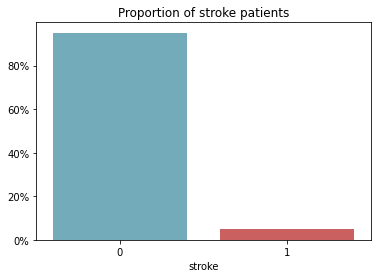

<Figure size 1440x720 with 0 Axes>

In [6]:
def stroke_proportion(curr_df, title):
    g = sns.barplot(
        x='stroke',
        y='stroke',  
        alpha=.75,
        palette=['#3697b5', '#d11313'],
        edgecolor='black',
        linewidth=0,
        data=curr_df,
        estimator=lambda x: len(x) / len(curr_df) * 100
    )
    
    g.yaxis.set_major_formatter(mtick.PercentFormatter())
    g.set_ylabel('')

    plt.title(title)
    plt.figure(figsize=(20, 10))

stroke_proportion(df, "Proportion of stroke patients")

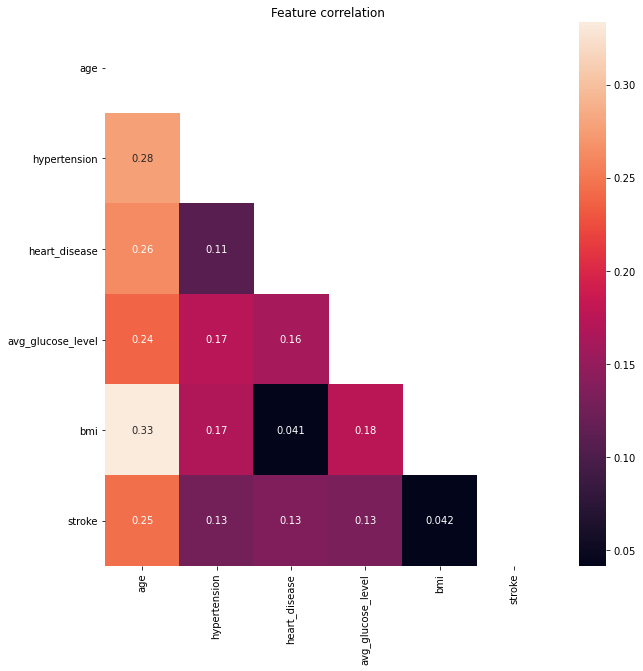

In [7]:
plt.figure(figsize=(10, 10))
plt.title('Feature correlation')

df_corr = df.drop(['id'], axis=1).corr()
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    df_corr, 
    linecolor='black', 
    mask=mask,
    annot=True)
plt.show()

In [8]:
## Trasforming textual values to numeric 
## gender, ever-married, work_type, Residence_type, smoking_status
cols_to_encode = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for i in range(len(cols_to_encode)):
    df[cols_to_encode[i]] = LabelEncoder().fit_transform(df[cols_to_encode[i]])

In [9]:
#Since the data is unbalanced, divide it for representation purposes
stroke_df = df[df['stroke'] == 1]
no_stroke_df = df[df['stroke'] == 0]

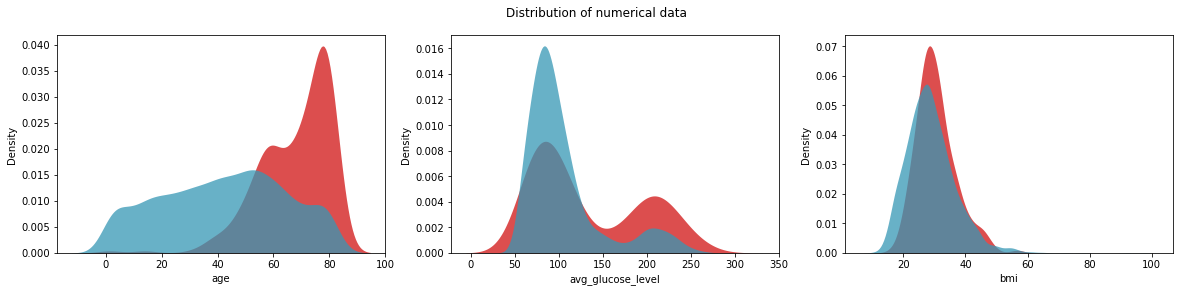

In [10]:
numeric_features = ['age', 'avg_glucose_level', 'bmi']
subplot = 131

fig = plt.figure(figsize=(20, 4))

for i in numeric_features:
    plt.subplot(subplot)

    sns.kdeplot(
        x=i,
        alpha=.75,
        color='#d11313',
        shade=True,
        linewidth=0,
        data=stroke_df
    )

    sns.kdeplot(
        x=i,
        alpha=.75,
        color='#3697b5',
        shade=True,
        linewidth=0,
        data=no_stroke_df
    )

    subplot += 1

plt.suptitle('Distribution of numerical data')
plt.show()

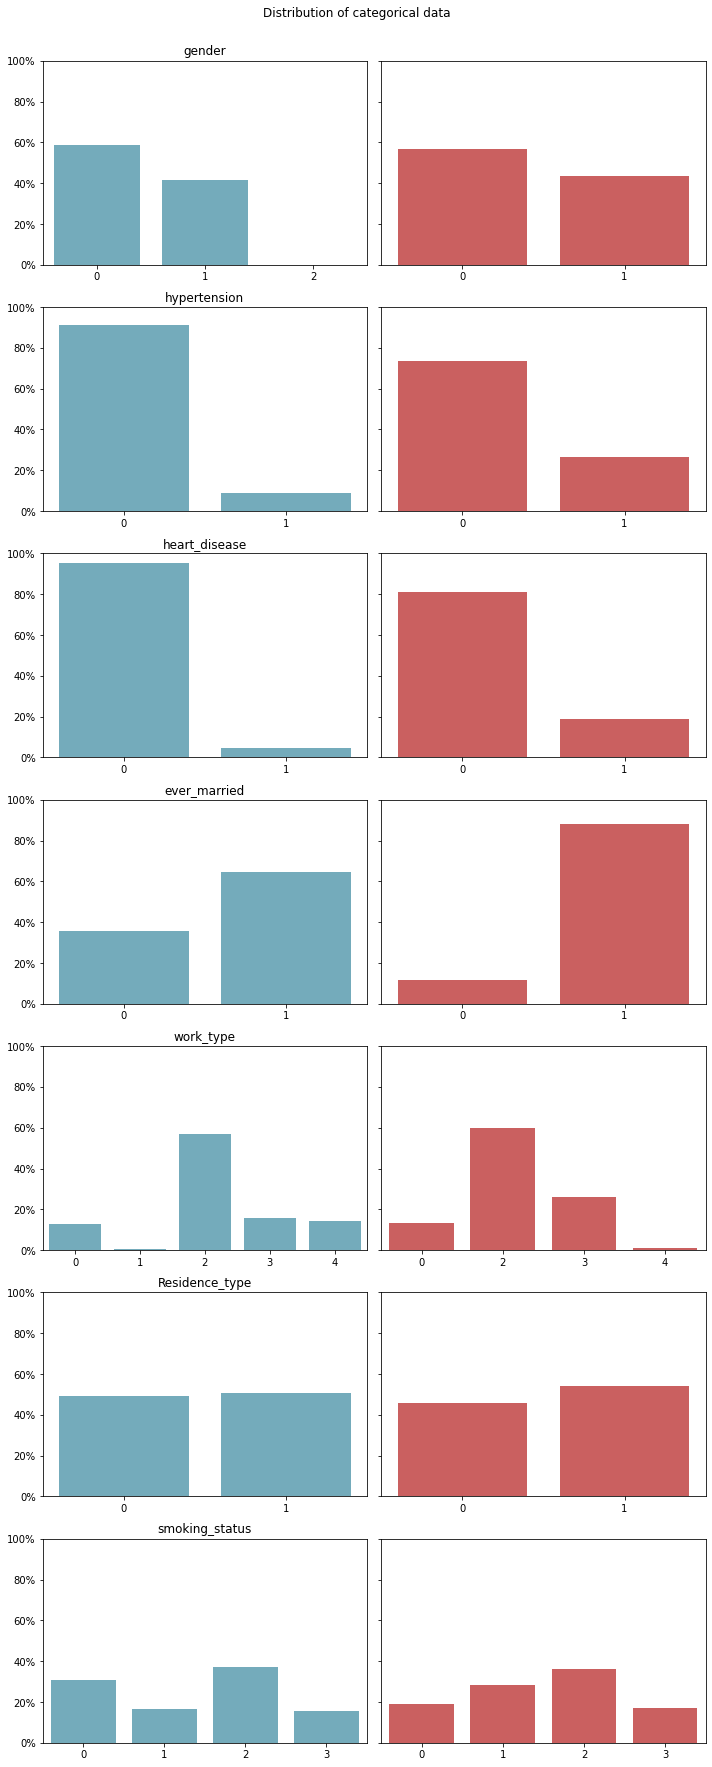

In [11]:
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

fig, ax = plt.subplots(len(categorical_features), 2, figsize=(10, 25), sharey=True)

for i in range(len(categorical_features)):
    feature = categorical_features[i]

    sns.barplot(
        x=feature, 
        y=feature,
        alpha=.75,
        color='#3697b5',
        data=no_stroke_df, 
        estimator=lambda x: len(x) / len(no_stroke_df) * 100,
        ax=ax[i,0]
    )

    sns.barplot(
        x=feature, 
        y=feature,
        alpha=.75,
        color='#d11313', 
        data=stroke_df, 
        estimator=lambda x: len(x) / len(stroke_df) * 100,
        ax=ax[i,1]
    )

    ax[i,0].set_title(feature)
    ax[i,0].set_ylabel('')
    ax[i,1].set_ylabel('')
    ax[i,0].set_xlabel('')
    ax[i,1].set_xlabel('')
    ax[i,0].yaxis.set_major_formatter(mtick.PercentFormatter())

fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle('Distribution of categorical data')
plt.show()

# CHAPTER 1 - DATA CURATION <a class="anchor" id="1"></a>

In [12]:
## Removing ids
df = df.drop(['id'], axis=1)

In [13]:
## Trasforming textual values to numeric 
## gender, ever-married, work_type, Residence_type, smoking_status
cols_to_encode = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for i in range(len(cols_to_encode)):
    df[cols_to_encode[i]] = LabelEncoder().fit_transform(df[cols_to_encode[i]])

In [14]:
## Handling NaN values
#TODO - For now remove
df.dropna(subset = ['bmi'], inplace=True)

## Handling unbalanced data (oversampling with SMOTE)

Synthesizing (training set) entries for the minority class with SMOTE

Shape before SMOTE: (3436, 10)
Shape after SMOTE: (6598, 10)


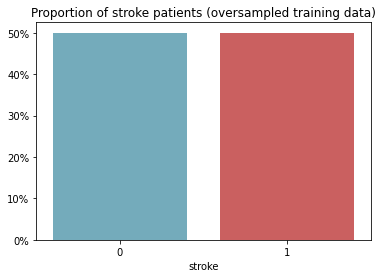

<Figure size 1440x720 with 0 Axes>

In [15]:
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']]
y = df[['stroke']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

oversample = SMOTE()
X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)

oversampled_df = X_train_SMOTE.assign(stroke = y_train_SMOTE)
stroke_proportion(y_train_SMOTE, "Proportion of stroke patients (oversampled training data)")
print("Shape before SMOTE: " + str(X_train.shape))
print("Shape after SMOTE: " + str(X_train_SMOTE.shape))

# CHAPTER 2 - DEVELOPMENT OF A DECISION TREE ALGORITHM <a class="anchor" id="2"></a>

In [16]:
# Leaf partitions only have prediction values
class Partition:
    '''
    Class used to represent a partition
    Partitions act as nodes in the Decision Tree

    Attributes
    ----------
    split_feature: str
        Feature chosen for splitting the partition
    split_value: float
        (Threshold) Value chosen for splitting the partition
    impurity_delta: float
        Reduction in impurity by splitting using `split_feature` and `split_value`
    impurity_feature_example: float
        Weighted sum of impurities for the partitions resulting from a split at `split_feature` and `split_value`
    prediction: float
        Predicted value (majority class) at the current partition
    '''
    def __init__(self, 
                 split_feature, 
                 split_value, 
                 impurity_delta, 
                 impurity_feature_example, 
                 prediction):
        self.split_feature = split_feature
        self.split_value = split_value
        self.impurity_delta = impurity_delta
        self.impurity_feature_example = impurity_feature_example
        self.prediction = prediction # TODO - Currently stored as float array
        self.left_part = None
        self.right_part = None

In [17]:
class DecisionTree:
    '''
    Class used to model the decision tree

    Attributes
    ----------
    strategy: str
        Strategy used to calculate the impurity of a partition
        Either `gini` (for gini index) or `entropy` (for information gain)
    max_depth: int
        Maximum total depth of the tree. Root node is at depth 1
    min_impurity_delta: float
        Threshold for the reduction in impurity needed to split a partition
        If the values is not met, the interested partition is turned into a leaf node
    min_size_part: int
        Threshold for the nr of examples needed to split a partition
        If the values is not met, the interested partition is turned into a leaf node
    '''
    def __init__(self, *,
                 strategy = 'gini',
                 max_depth = None, 
                 min_impurity_delta = None, 
                 min_impurity_part = None,
                 min_size_part = None):
        self.strategy = strategy
        self.max_depth = max_depth # Root depth is 1
        self.min_impurity_delta = min_impurity_delta
        self.min_impurity_part = min_impurity_part
        self.min_size_part = min_size_part

    def fit(self, 
            X, 
            y):
        '''
        Starts the process of building a Decision Tree from a training set

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples
        y: pandas.core.frame.DataFrame
            The training class labels
        '''
        self.tree = self.build_tree(X, y, self.max_depth)

    def build_tree(self, 
                   X, 
                   y, 
                   depth):
        '''
        Recursively builds a Decision Tree starting from a training set.

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples
        y: pandas.core.frame.DataFrame
            The training class labels
        depth: int
            Depth counter
            Used as stop condition for the recursive call when `max_depth` is defined for the Decision Tree

        Returns
        -------
        curr_part: Partition
            The root partition (node) of the Decision Tree
        '''
        # Majority class is set as the predicted value for the current partition
        prediction = Counter(y.values.flatten()).most_common()[0][0]

        # Update depth value
        if self.max_depth:
            if depth > 1:
                depth -= 1 
            else:
                return Partition(None, None, None, None, prediction) # Return as leaf

        # Check partition size
        if self.min_size_part and y.size < self.min_size_part:
            return Partition(None, None, None, None, prediction)

        split_feature, split_value, impurity_delta, impurity_feature_example = self.find_split(X, y.values.flatten())
        curr_part = Partition(split_feature, split_value, impurity_delta, impurity_feature_example, prediction)

        if(split_feature):
            merged_df = pd.concat([X, y], axis=1)

            merged_df_left = merged_df[merged_df[split_feature] < split_value]
            merged_df_right = merged_df[merged_df[split_feature] > split_value]

            curr_part.left_part = self.build_tree(
                merged_df_left.drop([y_train_SMOTE.columns[0]], axis=1), 
                merged_df_left[[y_train_SMOTE.columns[0]]], 
                depth) # Left

            curr_part.right_part = self.build_tree(
                merged_df_right.drop([y_train_SMOTE.columns[0]], axis=1), 
                merged_df_right[[y_train_SMOTE.columns[0]]],
                depth) # Right  

        return curr_part

    def predict(self, 
                X):
        '''
        Traverses the Decision Tree to predict a class value (label) for each input example

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples

        Returns
        ----------
        y: pandas.core.frame.DataFrame
            The predicted class labels
        '''
        y = np.zeros((X.shape[0])) # TODO - Array shape is fine?

        for index, example in X.reset_index().iterrows(): # TODO - Think if reset index is correct
            curr_part = self.tree

            while curr_part.right_part:
                if example[curr_part.split_feature] < curr_part.split_value:
                    curr_part = curr_part.left_part
                else:
                    curr_part = curr_part.right_part
            y[index] = curr_part.prediction

        return y

    # Both gini index and entropy/information gain are measures of the impurity of a node.
    def calc_impurity(self, 
                      class_occ, 
                      size_part):
        '''
        Calculates the impurity of a partition based on the chosen strategy

        Parameters
        ----------
        class_occ: Counter
            Nr of occurrences of each class value 
        size_part:
            Nr of examples in the current partition
        Returns
        ----------
        ret:
            The impurity value of the partition
        '''
        if self.strategy == 'gini':
            return (1 - sum((class_occ[curr_class]/size_part)**2 for curr_class in class_occ))
        elif self.strategy == 'entropy':
            ret = 0
            for curr_class in class_occ:
                if class_occ[curr_class]/size_part > 0:
                    ret -= class_occ[curr_class]/size_part * math.log(class_occ[curr_class]/size_part, 2)
            return ret

    def find_split(self, 
                   X, 
                   y):
        '''
        Finds the best split feature and threshold for a given partition

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples
        y: pandas.core.frame.DataFrame
            The training class labels

        Returns
        ----------
        split_feature: str
            Feature chosen for splitting the partition
        split_value: float
            (Threshold) Value chosen for splitting the partition
        impurity_delta: float
            Reduction in impurity by splitting using `split_feature` and `split_value`
        impurity_feature_example: float
            Weighted sum of impurities for the partitions resulting from a split at `split_feature` and `split_value`
        '''
        # Initialize the return values
        split_feature, split_value, impurity_delta, impurity_feature_example = None, None, None, None

        # Calculate the occurences of each class in the partition
        class_occ_part = Counter(y)

        # Return if the partition is pure
        if sum(class_occ_part[i] > 0 for i in class_occ_part) == 1:
            return split_feature, split_value, impurity_delta, impurity_feature_example

        # Calculate the impurity of the current partition
        size_part = y.size
        impurity_part = self.calc_impurity(class_occ_part, size_part)

        if self.min_impurity_part and impurity_part < self.min_impurity_part:
            return split_feature, split_value, impurity_delta, impurity_feature_example

        impurity_delta = 0

        # Loop through all features
        for feature in X:
            # Skip ahead if the feature has only one value
            if X[feature].nunique() == 1:
                continue

            # Sort the examples in increasing order for the selected feature
            # Consider the midpoint between two (different) adjecent values as a possible split point
            feature_sorted, y_sorted = zip(*sorted(zip(X[feature].values.flatten(), y), key=lambda x: x[0])) #TODO - Change value flatten

            # Go through the sorted feature while keeping track of class occurences on each side (/partition)
            class_occ_left = Counter({0:0, 1:0}) # TODO - Improve this
            class_occ_right = class_occ_part.copy() # Same as occurences of each class in the partition

            for example in range(1, size_part):
                example_class = y_sorted[example-1]

                # Increment the example class on the left, decrement it on the right
                class_occ_left[example_class] += 1
                class_occ_right[example_class] -= 1

                # Skip ahead if two adjacent values are equal
                if feature_sorted[example] == feature_sorted[example - 1]:
                    continue

                # Calculate the impurity of each side
                size_left = example
                impurity_left = self.calc_impurity(class_occ_left, size_left)

                size_right = size_part - example
                impurity_right = self.calc_impurity(class_occ_right, size_right)
                
                # Calculate the weighted sum of impurities (obtained with selected feature at current example)
                curr_impurity_feature_example = ((size_left/size_part) * impurity_left) + ((size_right/size_part) * impurity_right)

                # Calculate the reduction in impurity with the current split
                curr_impurity_delta = impurity_part - curr_impurity_feature_example

                if(self.min_impurity_delta and curr_impurity_delta < self.min_impurity_delta):
                    continue

                if(curr_impurity_delta > impurity_delta):
                    split_feature = feature
                    split_value = (feature_sorted[example] + feature_sorted[example-1]) / 2
                    impurity_delta = curr_impurity_delta
                    impurity_feature_example = curr_impurity_feature_example

        return split_feature, split_value, impurity_delta, impurity_feature_example

In [27]:
class RandomForest:
    '''
    Class used to model the random forest

    Attributes
    ----------
    forest_size: int
        Controls the nr of trees in the forest
    bagging: bool
        Decides whether bootstrap aggregation is used for the tree input data
        When set to False, the whole dataset is used for each tree in the forest
    strategy: str
        Strategy used to calculate the impurity of a partition in a tree
        Either `gini` (for gini index) or `entropy` (for information gain)
    max_depth: int
        Maximum total depth of the trees. Root node is at depth 1
    min_impurity_delta: float
        Threshold for the reduction in impurity needed to split a partition in a tree
        If the values is not met, the interested partition is turned into a leaf node
    min_size_part: int
        Threshold for the nr of examples needed to split a partition in a tree
        If the values is not met, the interested partition is turned into a leaf node
    '''
    def __init__(self, *,
                 forest_size = 100,
                 bagging = True,
                 strategy = 'gini',
                 max_depth = None, 
                 min_impurity_delta = None, 
                 min_impurity_part = None,
                 min_size_part = None):
        self.strategy = strategy
        self.max_depth = max_depth # Root depth is 1
        self.bagging = bagging
        self.forest_size = forest_size
        self.min_impurity_delta = min_impurity_delta
        self.min_impurity_part = min_impurity_part
        self.min_size_part = min_size_part

In [18]:
tree_test = DecisionTree(strategy='entropy')
tree_test.fit(X_train_SMOTE,y_train_SMOTE)

test_array = tree_test.predict(X_test)

In [19]:
type(X_train_SMOTE)

pandas.core.frame.DataFrame

# CHAPTER 3 - TRAINING THE ALGORITHM <a class="anchor" id="3"></a>

# CHAPTER 4 - COMPARING RESULTS WITH AN EXISTING SOLUTION <a class="anchor" id="4"></a>

In [20]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train_SMOTE, y_train_SMOTE)
print(cross_val_score(clf,X_train_SMOTE,y_train_SMOTE,cv=10,scoring='f1').mean())

0.9220899317947489


In [21]:
test2 = clf.predict(X_test)

8, 'X[7] <= 67.355\nentropy = 1.0\nsamples = 4\nvalue = [2, 2]'),
 Text(259.1092512854814, 126.1152, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(260.9007482964759, 126.1152, 'X[7] <= 78.26\nentropy = 0.918\nsamples = 3\nvalue = [1, 2]'),
 Text(260.0049997909786, 117.41760000000001, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(261.79649680197315, 117.41760000000001, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(260.9007482964759, 143.5104, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(261.79649680197315, 152.208, 'entropy = 0.0\nsamples = 9\nvalue = [9, 0]'),
 Text(281.86686175327117, 178.3008, 'X[6] <= 0.5\nentropy = 0.396\nsamples = 1049\nvalue = [82, 967]'),
 Text(273.8891016261862, 169.60320000000002, 'X[7] <= 236.144\nentropy = 0.247\nsamples = 732\nvalue = [30, 702]'),
 Text(270.75398185694576, 160.9056, 'X[7] <= 201.259\nentropy = 0.295\nsamples = 558\nvalue = [29, 529]'),
 Text(267.17098783495675, 152.208, 'X[8] <= 42.467\nentropy = 0.161\nsamples 

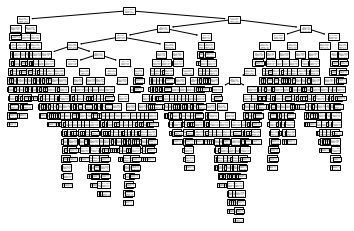

In [22]:
tree.plot_tree(clf)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
rf_cv = cross_val_score(rf_pipeline,X_train_SMOTE,y_train_SMOTE,cv=10,scoring='f1')
print('Random Forest mean :',cross_val_score(rf_pipeline,X_train_SMOTE,y_train_SMOTE,cv=10,scoring='f1').mean())

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataCo

# CHAPTER 5 - CONCLUSIONS <a class="anchor" id="5"></a>